In [1]:
import time
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib inline
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)
import pandas as pd

In [2]:
def datacube_dir(fileseq, snap, cell_size=1.,
        faceon=False, style='', tauv=1.0, mu=0.3, cir_fib=False,
        with_metal=False, one_comp_dust=False, with_PSF=False):
    """
    find the dir of the datacube. The dir is where RSS are stored
    cir_fib: use the circular fiber
    """
    #where we store the output of the SEDmorph code
    str_snap = str(snap).zfill(3)
    #dir_out = '/share/data/yz69/SEDMORPH/SimnsGadget3_output/'+fileseq+'/'
    dir_out = '../'+fileseq+'/'

    fits_outstr = "_tauv%0.1f_mu%0.1f" %(tauv, mu)
    if faceon:
        fits_outstr=fits_outstr+'_fo'     
    if one_comp_dust:
        fits_outstr=fits_outstr+'_one_comp_dust'     
    if style.lower() == 'sedmorph':
        style=''
    elif style=="":
        pass
    else:
        style='_'+style
    if cir_fib:
        data_cube_dir = "DataCube"+fits_outstr+'_'+str_snap+style+'_cir_radius_%0.2f' %(cell_size)
    else:
        data_cube_dir = "DataCube"+fits_outstr+'_'+str_snap+style+'_size_%0.2f' %(cell_size)
    if with_metal:
        data_cube_dir=data_cube_dir+'_with_metal'
    if with_PSF:
        data_cube_dir=data_cube_dir+'_with_PSF'
    data_cube_dir = dir_out+data_cube_dir + '/'
    
    return data_cube_dir

def load_cubes(fileseq, snap, fib_size=0.79, style='star_age', tauv=1.0, mu=0.3,  with_metal=True,
                 cir_fib=True,with_PSF=True, faceon=False, one_comp_dust=False):
    
    #cube_dir=datacube_dir(fileseq, snap, cell_size=fib_size,
    #             style=style,  with_metal=with_metal,
    #             cir_fib=True,with_PSF=with_PSF )
    cube_dir = '../snap'+str(snap)+'/'
    if with_PSF == True:
        cube_dir += 'with_PSF/'
    else: cube_dir += 'no_PSF/'

    fits_outstr = "_tauv%0.1f_mu%0.1f" %(tauv, mu)
    if faceon:
        fits_outstr=fits_outstr+'_fo'
    if one_comp_dust:
        fits_outstr=fits_outstr+'_one_comp_dust'
    datacube_fits = cube_dir+"DataCube_"+fileseq+fits_outstr+'_'+str(snap).zfill(3)+style+'.fits'
#     print datacube_fits
    wave = fits.getdata(datacube_fits, extname="WAVELENGTH")['wave']
    cube_tau = fits.getdata(datacube_fits, extname="DATACUBE_DUSTTED")
    cube_notau = fits.getdata(datacube_fits, extname="DATACUBE_NODUST")
    return wave, cube_tau, cube_notau

In [24]:
# simulation
fileseq = '2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP'
remarks = '_SNR15_outshining_test'
snap = 119
# type of the cube
style = 'star_age'
with_metal = True
with_PSF = True

# type of the spectrum
dust = True
noise = True
SNR = 15
spec_lims = [3000,10000]

In [25]:
# paramters
kpc_in_arcsec = 0.79134391 # 1 arcsec is corresponding to 0.8 kpc at z=0.04
fib_size = 0.79134391 # as its radius is 1 arcsec
pixel_size = 0.5 * kpc_in_arcsec # in side length in kpc
print("size of the a pixel: %.3f kpc" %pixel_size)
print("size of the a pixel: %.3f kpc" %pixel_size)
print("size of the a pixel: %.3f kpc" %pixel_size)

size of the a pixel: 0.396 kpc
size of the a pixel: 0.396 kpc
size of the a pixel: 0.396 kpc


### Load the cube

In [26]:
wave, cube_tau, cube_notau = load_cubes(fileseq, snap, fib_size=fib_size, style=style,
                        with_metal=with_metal, cir_fib=True,with_PSF=with_PSF)

### Slice of the cubes at a given wavelength

Text(0, 0.5, 'y[pixel]')

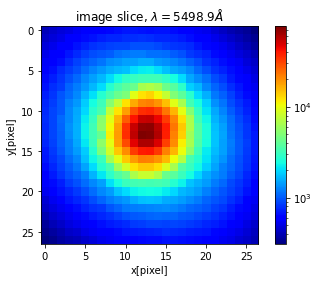

In [27]:
idx = 8441
plt.imshow(cube_tau[idx], norm=LogNorm(), cmap='jet')
plt.colorbar()
plt.title( r"image slice, $\lambda=%.1f\AA$" %wave[idx]  )
plt.xlabel('x[pixel]')
plt.ylabel('y[pixel]')

In [28]:
def plot_spectrum(wave, lum_spectrum, z=0.04, plot=True):
    obs_wave = wave*(1+z)  # converting wavelengths from rest frame to observed
    # 3.826*10**33 = 1 Lsun in erg s^-1
    # cosmo.luminosity_distance(0.04).value gives distance in Mpc at z=0.04, multiply by 1000 to get kpc
    # 3.0856*10**21 = 1 kpc in cm
    # equation is Spectral energy = luminosity * (Lsun in erg s ^-1) / 4 pi (r in cm)**2
    spectrum = lum_spectrum*3.826*10**33/(4*np.pi*((cosmo.luminosity_distance(0.04).value*1000)*(3.0856*10**21))**2)
    if plot==True:
        plt.plot(obs_wave, spectrum*10**18)
        plt.xlim(3000,10000)
        #plt.xscale('log')
        #plt.yscale('log')
        plt.xlabel('wavelength[$\AA$]', fontsize=15)
        plt.ylabel('$f_\lambda \;/\; 10^{-18} \;erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$', fontsize=15)
        plt.show()
    return obs_wave, spectrum

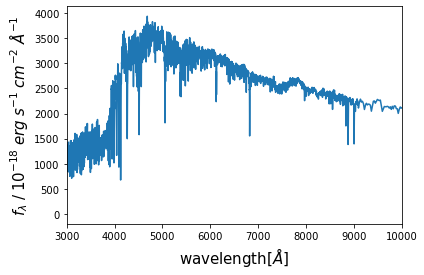

In [29]:
if dust == True:
    cubecube = cube_tau.copy()
else: cubecube = cube_notau.copy()
z_wave, spectrum = plot_spectrum(wave, np.sum(cubecube,axis=(1,2)),z=0.04)

In [30]:
def gen_save_name(fileseq, snap, with_PSF, with_dust, with_noise, remarks=None):
    directory = '../snap'+str(snap)+'/'
    save_name = 'Spectrum_'+fileseq
    if with_PSF == True:
        directory += 'with_PSF/'
        save_name += '_with_PSF'
    else:
        directory += 'no_PSF/'
        save_name += '_no_PSF'
    if with_dust == True:
        directory += 'with_dust/'
        save_name += '_with_dust'
    else:
        directory += 'no_dust/'
        save_name += '_no_dust'
    if with_noise == True:
        save_name += '_with_noise'
    if remarks is not None:
        if remarks[0] == '_':
            save_name += remarks
        else: save_name += '_'+remarks
    save_name += '.csv'
    return directory+save_name

def noise_and_error(spectrum, SNR, noise):
    #setting spectrum obs error to be 15% of flux density
    spectrum_err = spectrum/SNR
    
    if noise == True:
        #adding artificial noise to the spectrum according to the SNR set
        #noise added is gaussian with sigma = signal/SNR
        spectrum_1sigma = spectrum/SNR
        spectrum_ = spectrum+np.random.randn(len(spectrum_1sigma))*spectrum_1sigma
    else:
        spectrum_ = spectrum
    return spectrum_, spectrum_err

spectrum_, spectrum_err = noise_and_error(spectrum, SNR, noise)

save_df = pd.DataFrame({'observed-wave[AA]':z_wave,'flux[10^-16 erg/s/cm^2/AA]':spectrum_*10**16, 'noise[10^-16 erg/s/cm^2/AA]':spectrum_err*10**16})
save_name = gen_save_name(fileseq, snap, with_PSF, dust, noise, remarks=remarks)
print(save_name)
save_df[save_df['observed-wave[AA]'].between(*spec_lims)].to_csv(save_name, index=False)

../snap119/with_PSF/with_dust/Spectrum_2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_with_dust_with_noise_SNR15_outshining_test.csv
